# Classifier comparison on EFRI directionality decoding task
We compare the performance of MORF against several other classifiers on raw stereo-EEG (sEEG) data. Patients in the EFRI cohort were tasked with using a manipulandum to maneuver a cursor from a central starting point to a target zone located either up, down, left, or right of center.

## Experimental Setup
The raw sEEG data is a multivariate time series of dimension $N \times C \times T$, where $N$ is the number of trials the task was performed, $C$ is the number of sEEG implantations, and $T$ is the number of time steps. Each patient typically performed around $N=75$ to $N=100$ trials of the experiment successfully and had $C=70$ to $C=100$ channel recordings. The time window in consideration begins -0.2 s before the recorded instance the patient leaves the central starting point until 0.5 s after they have left the central starting point. The sampling frequency was downsampled to 500 Hz, yielding $T = 350$. The labels are integer-encoded directions $\{0,1,2,3\}$ corresponding to down, right, up, and left, respectively.

We analyze the performance of several classifiers against MORF in this multi-class classification problem, primarily evaluating based on the macro-averaged one vs. rest area under the receiver operating curve (OvR AUROC). We show the results over 5-fold stratified cross validation.

by Chester Huynh and Adam Li, *March 2021*

In [1]:
import json
import os
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from mne_bids import BIDSPath
from ptitprince import RainCloud

plt.rcParams.update({
    "font.family": "sans-serif", 
    "font.size": 22
})

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Directionality decoding plots

In [2]:
import json
cohort = ["efri07", "efri13", "efri14", "efri18", "efri20"]
derivatives_path = Path(
    "/Users/ChesterHuynh/OneDrive - Johns Hopkins/efri/derivatives/workstation_output/mtmorf/decode_directionality/"
)

cohort_clf_scores = defaultdict(dict)

# Create mapping from saved filename and figure name
clf_names_for_figure = {
    "MT-MORF": "MORF", 
    "SPORF": "SPORF",
    "RF": "RF", 
    "kNN": "kNN",
    "XGB": "XGB", 
    "MLP": "MLP", 
    "ConvNet": "ConvNet"
}
for subject in cohort:
    for clf_fname, clf_figure_name in clf_names_for_figure.items():
        with open(
            derivatives_path / f"{subject}/tmin=-0.2_tmax=0.5/time_domain/{subject}_{clf_fname}_results.json", "r"
        ) as f:
            cohort_clf_scores[subject][clf_figure_name] = json.load(f)

In [3]:
def plot_classifier_comparison(cohort_clf_scores, metric="roc_auc_ovr"):
    if metric not in ["roc_auc_ovr", "accuracy", "cohen_kappa_score"]:
        raise ValueError("metric must be one of roc_auc_ovr, accuracy or cohen_kappa_score")

    df = []
    for subject, clf_scores in cohort_clf_scores.items():
        for clf_name, scores in clf_scores.items():
            df.append([subject, clf_name, scores[f"test_{metric}"]])
    df = pd.DataFrame(df, columns=["Subject", "Classifier Name", metric])
    df = pd.DataFrame({"Subject": np.repeat(df["Subject"].values, df[metric].str.len()),
                            "Classifier Name": np.repeat(df["Classifier Name"].values, df[metric].str.len()),
                            metric: np.concatenate(df[metric].values)})

    width = 16
    aspect_ratio = 3/4  # 4:3 aspect ratio
    fig, ax = plt.subplots(figsize=(width, width*aspect_ratio), dpi=300)
    palette = {
        "MORF": "r", 
        "SPORF": "r", 
        "RF": "gray", 
        "kNN": "gray", 
        "XGB": "gray", 
        "MLP": "gray", 
        "ConvNet": "gray"
    }
    RainCloud(x="Classifier Name", y=metric, data=df, ax=ax, palette=palette)
    
    # Set labels and titles
    ylabel = {
        "roc_auc_ovr": "ROC AUC One vs. Rest",
        "accuracy": "Accuracy",
        "cohen_kappa_score": "Cohen Kappa Score"
    }
    ax.set_ylabel(ylabel[metric])
    ax.set_title(f"Raw sEEG Directionality Decoding Cross-Validated Classifier Performance")
    legendlabel = {
        "roc_auc_ovr": "ROC AUC OvR (MORF)",
        "accuracy": "Accuracy (MORF)",
        "cohen_kappa_score": "Cohen Kappa Score (MORF)",
    }
    line = ax.axhline(
        np.median(df[df["Classifier Name"] == "MORF"][metric]), 
        label=f"Median {legendlabel[metric]}", ls="--", lw=2, c='r', alpha=0.7
    )

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.legend([line],[line.get_label()], frameon=False)
    return ax

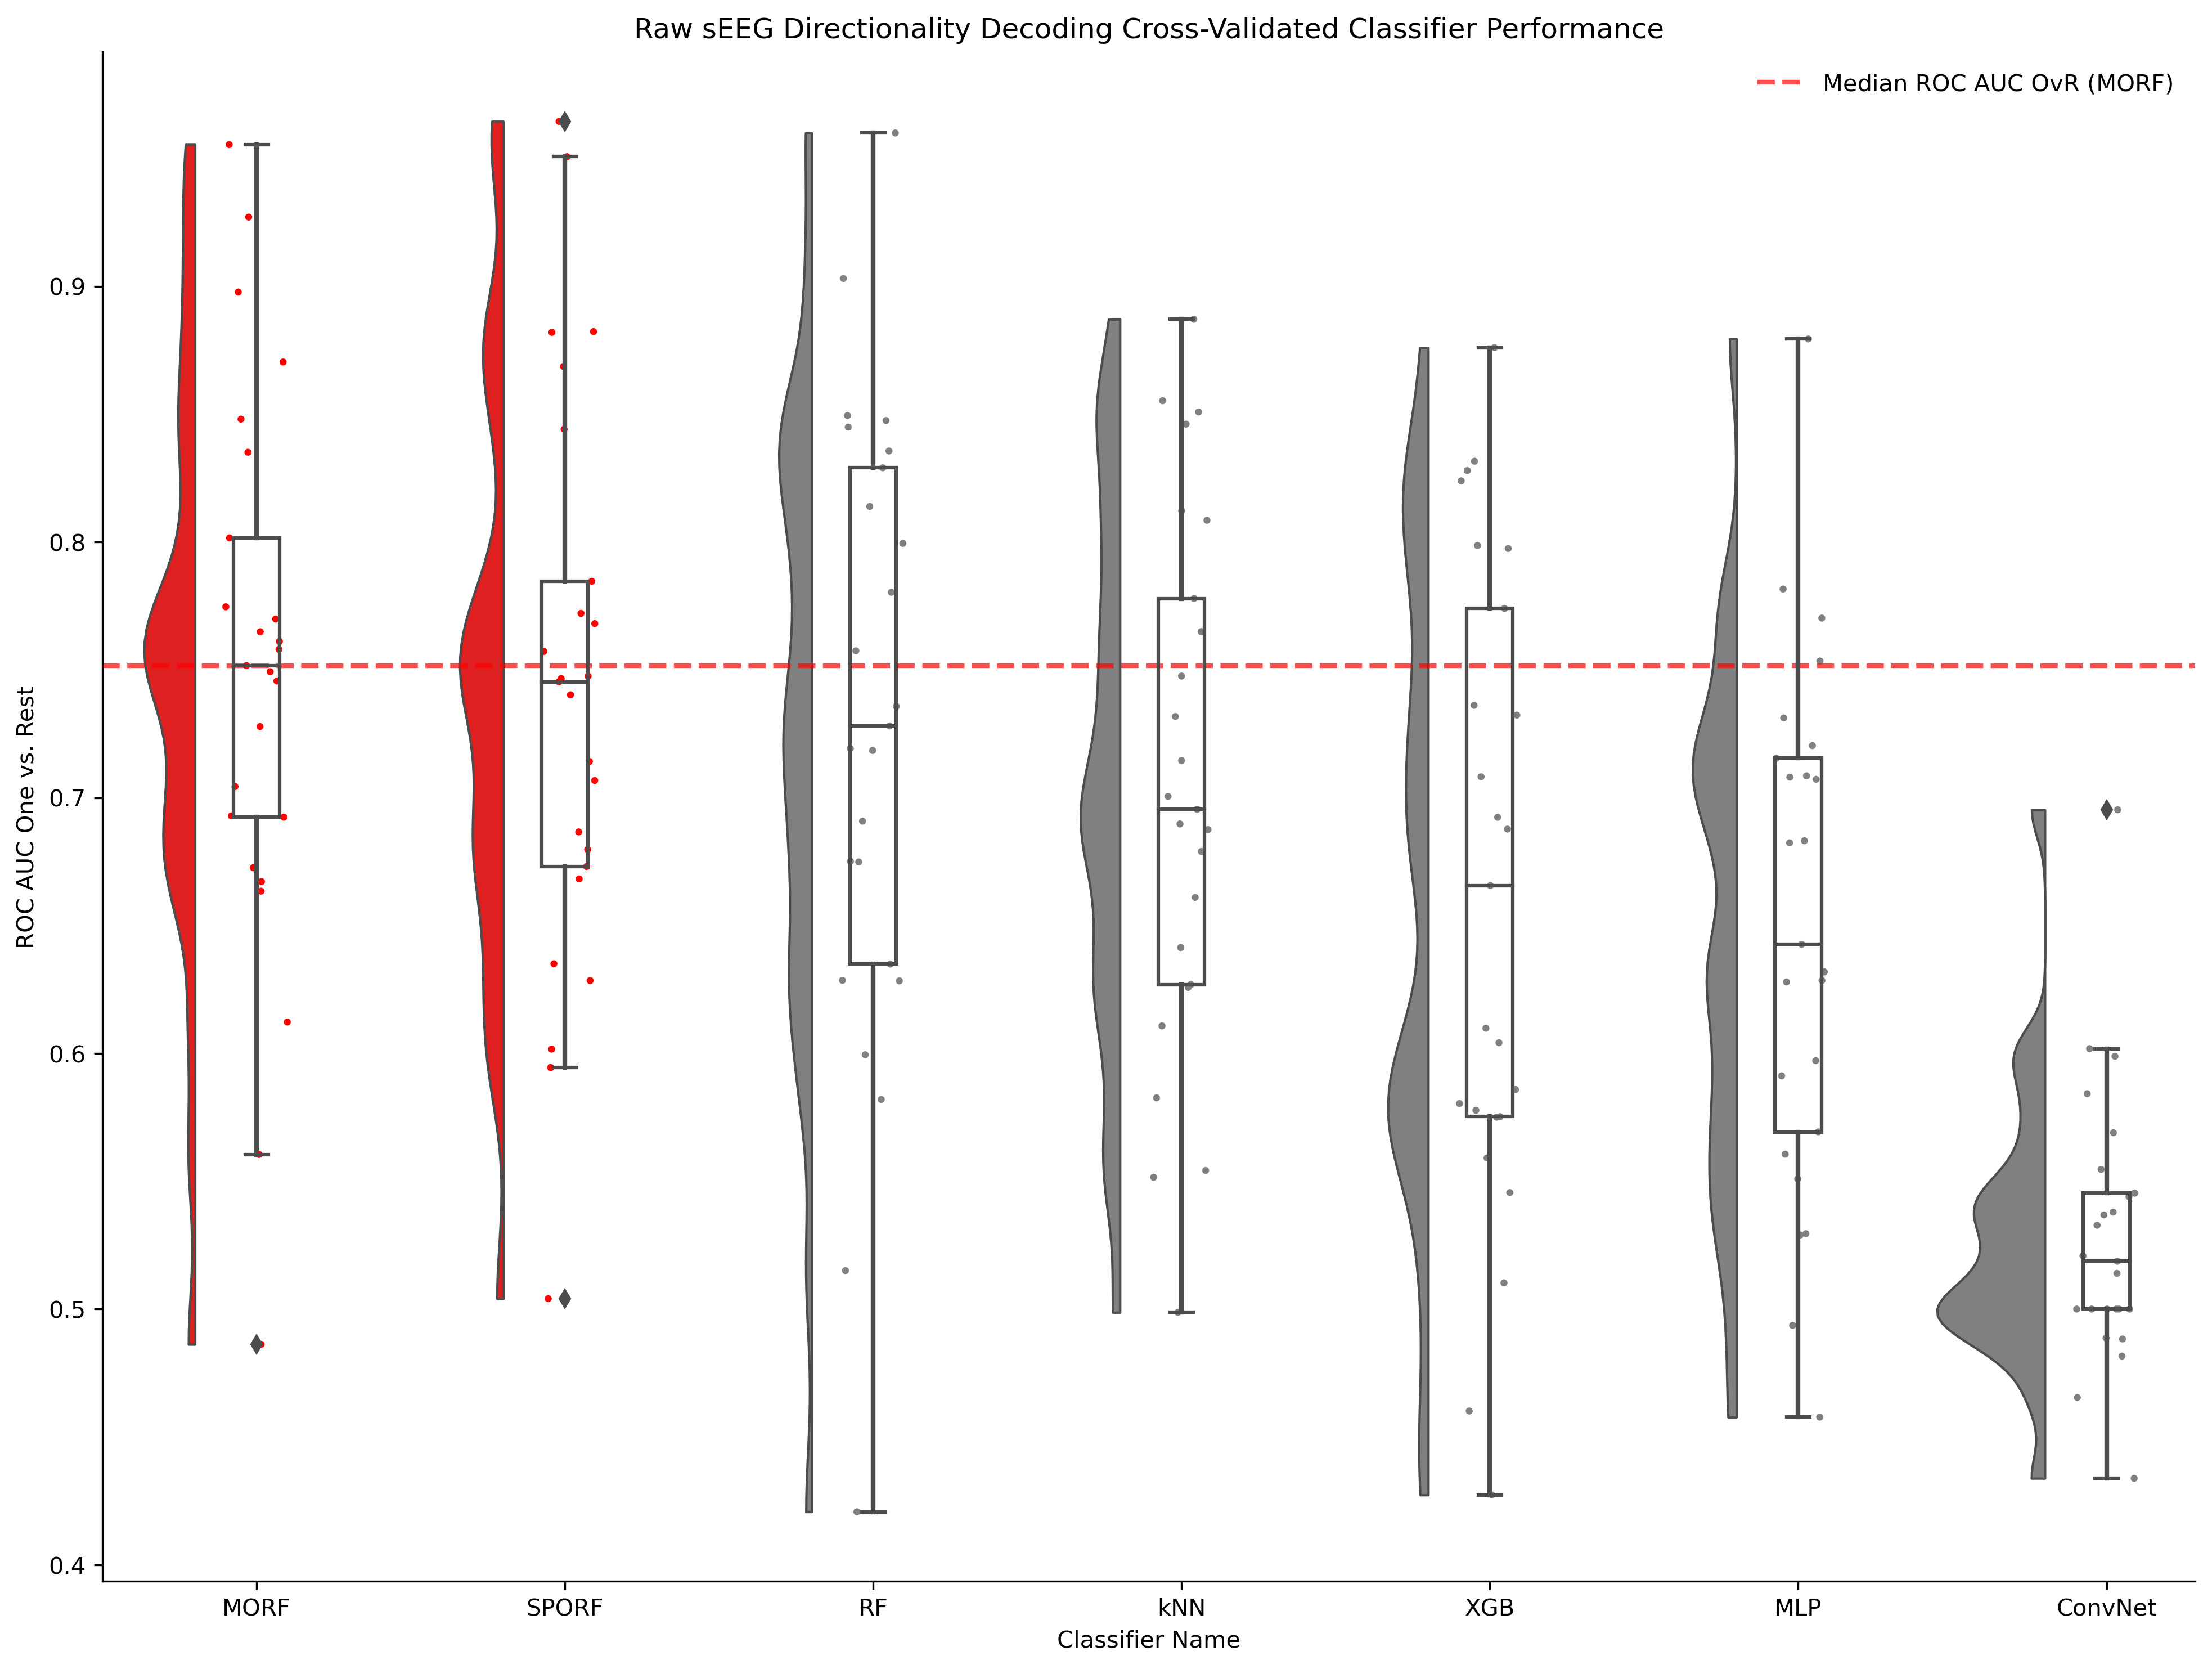

In [4]:
plot_classifier_comparison(cohort_clf_scores, "roc_auc_ovr");

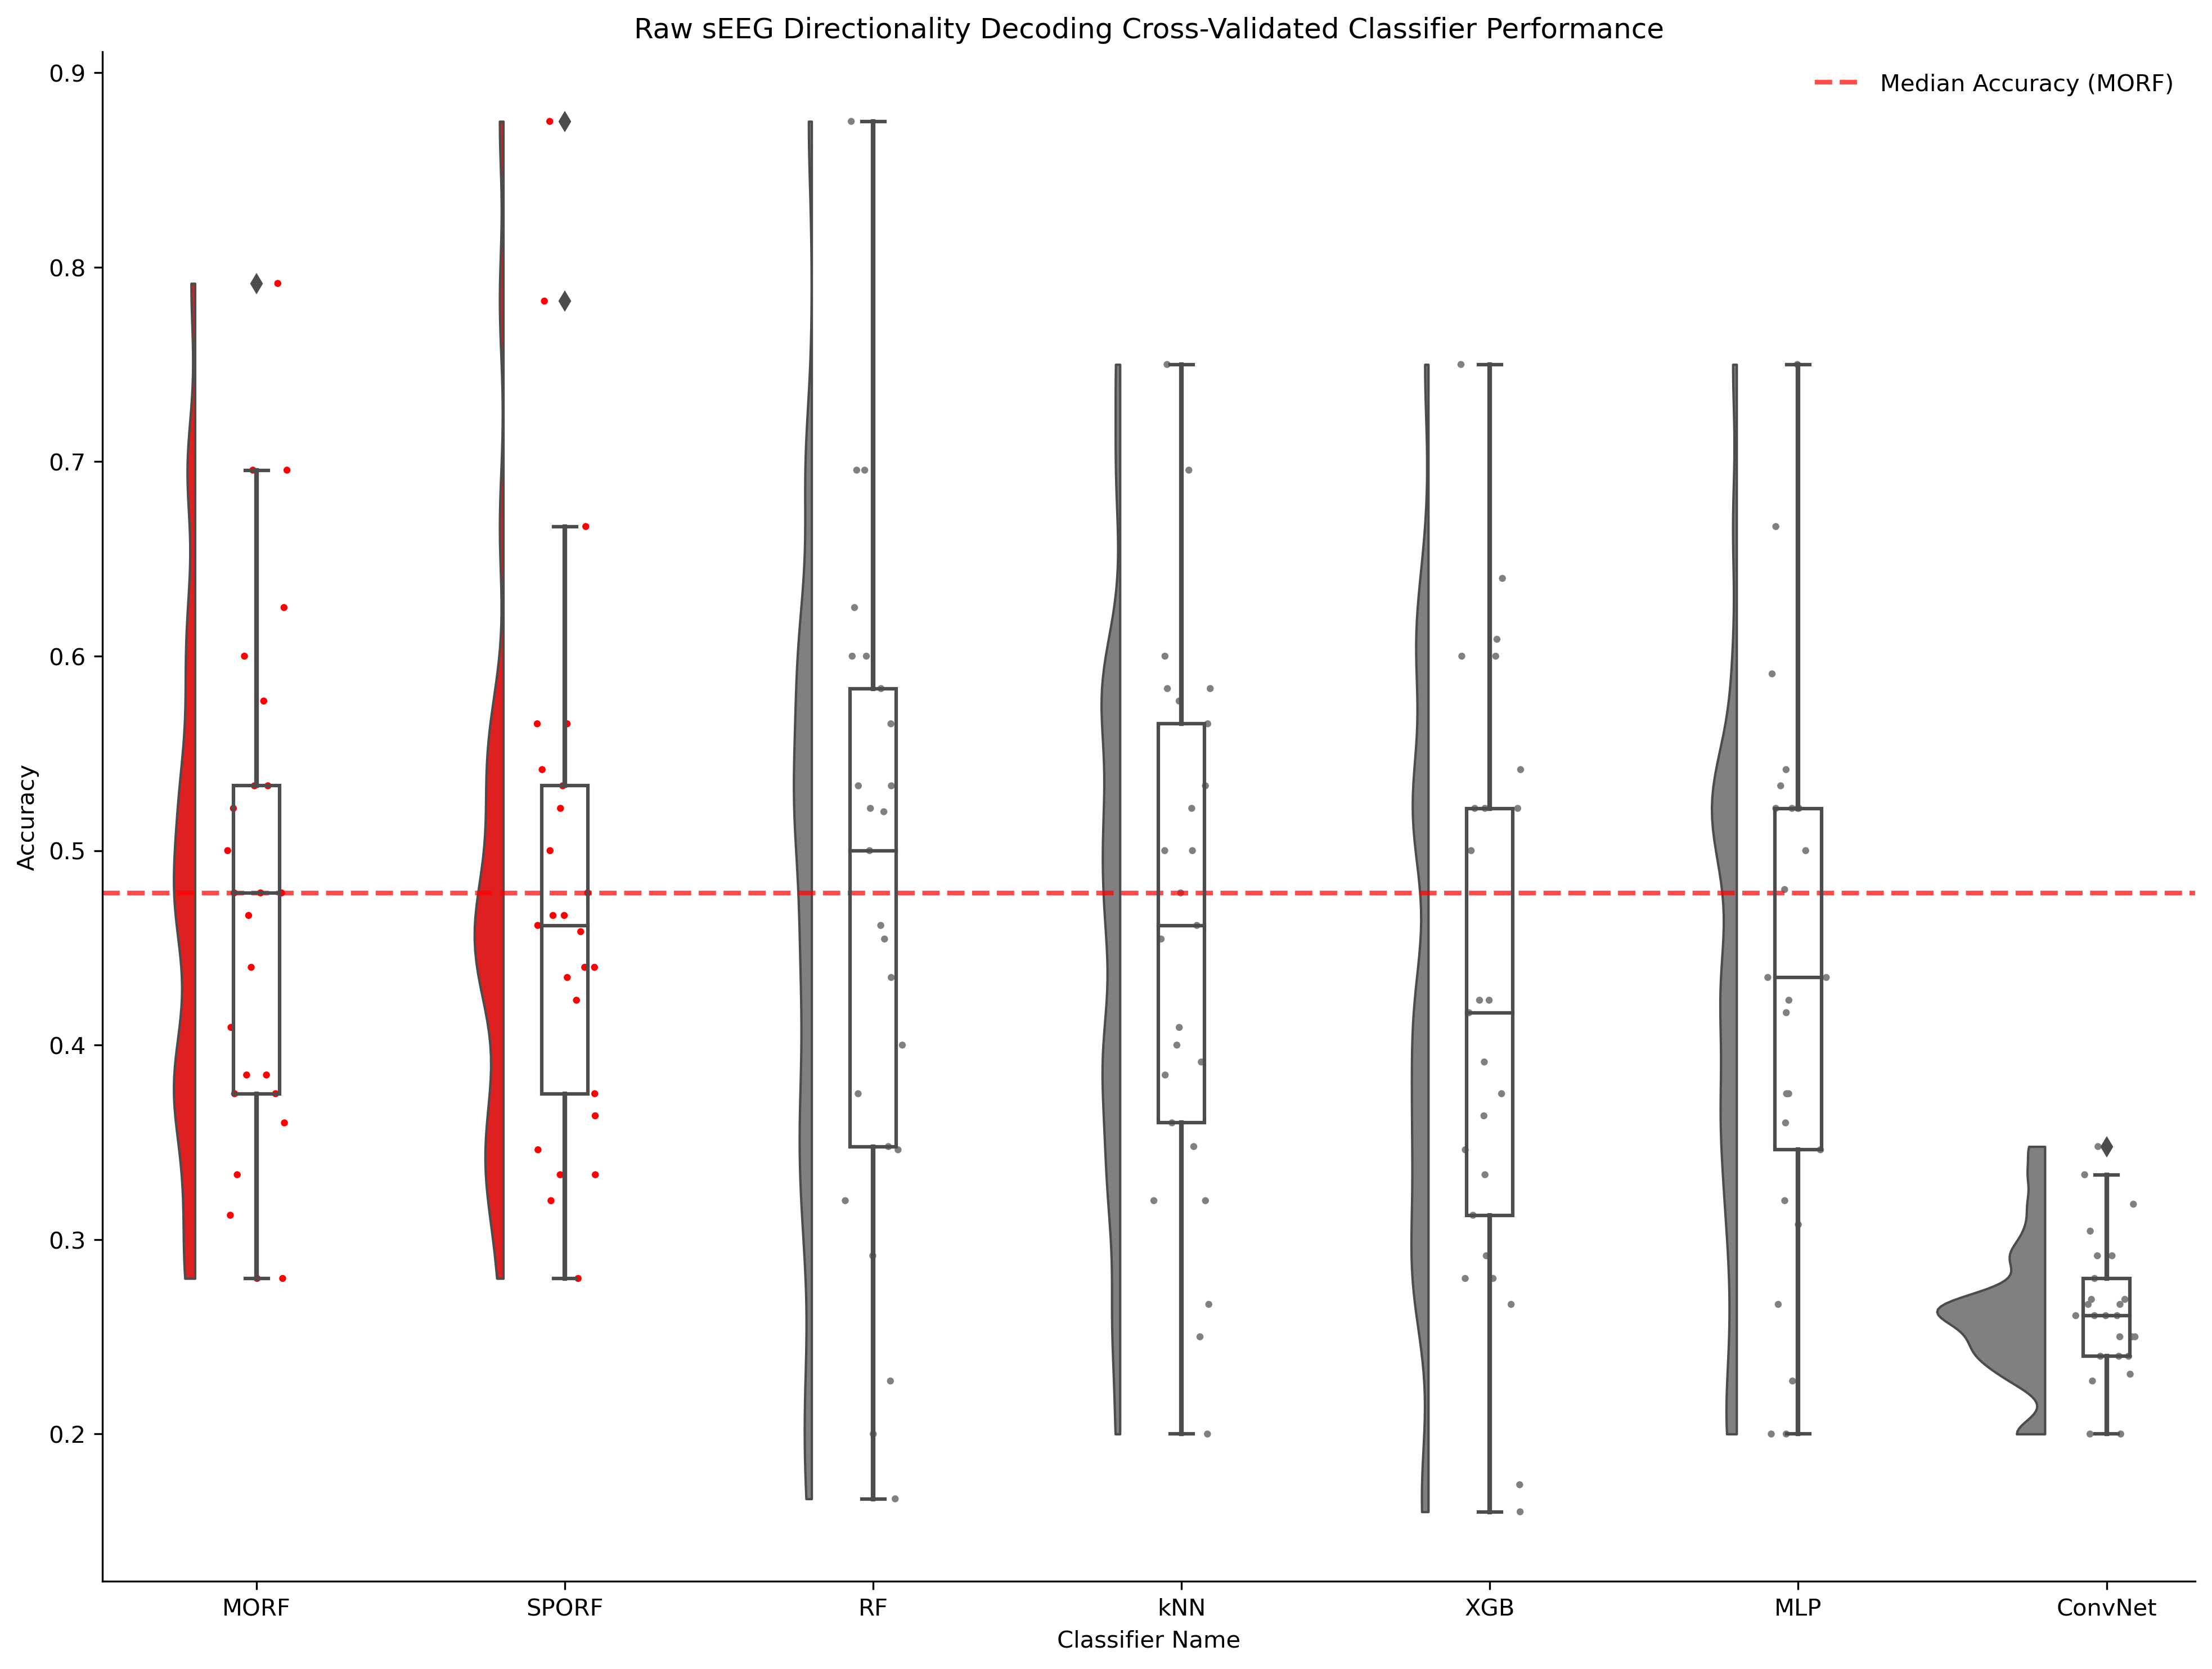

In [5]:
plot_classifier_comparison(cohort_clf_scores, "accuracy");

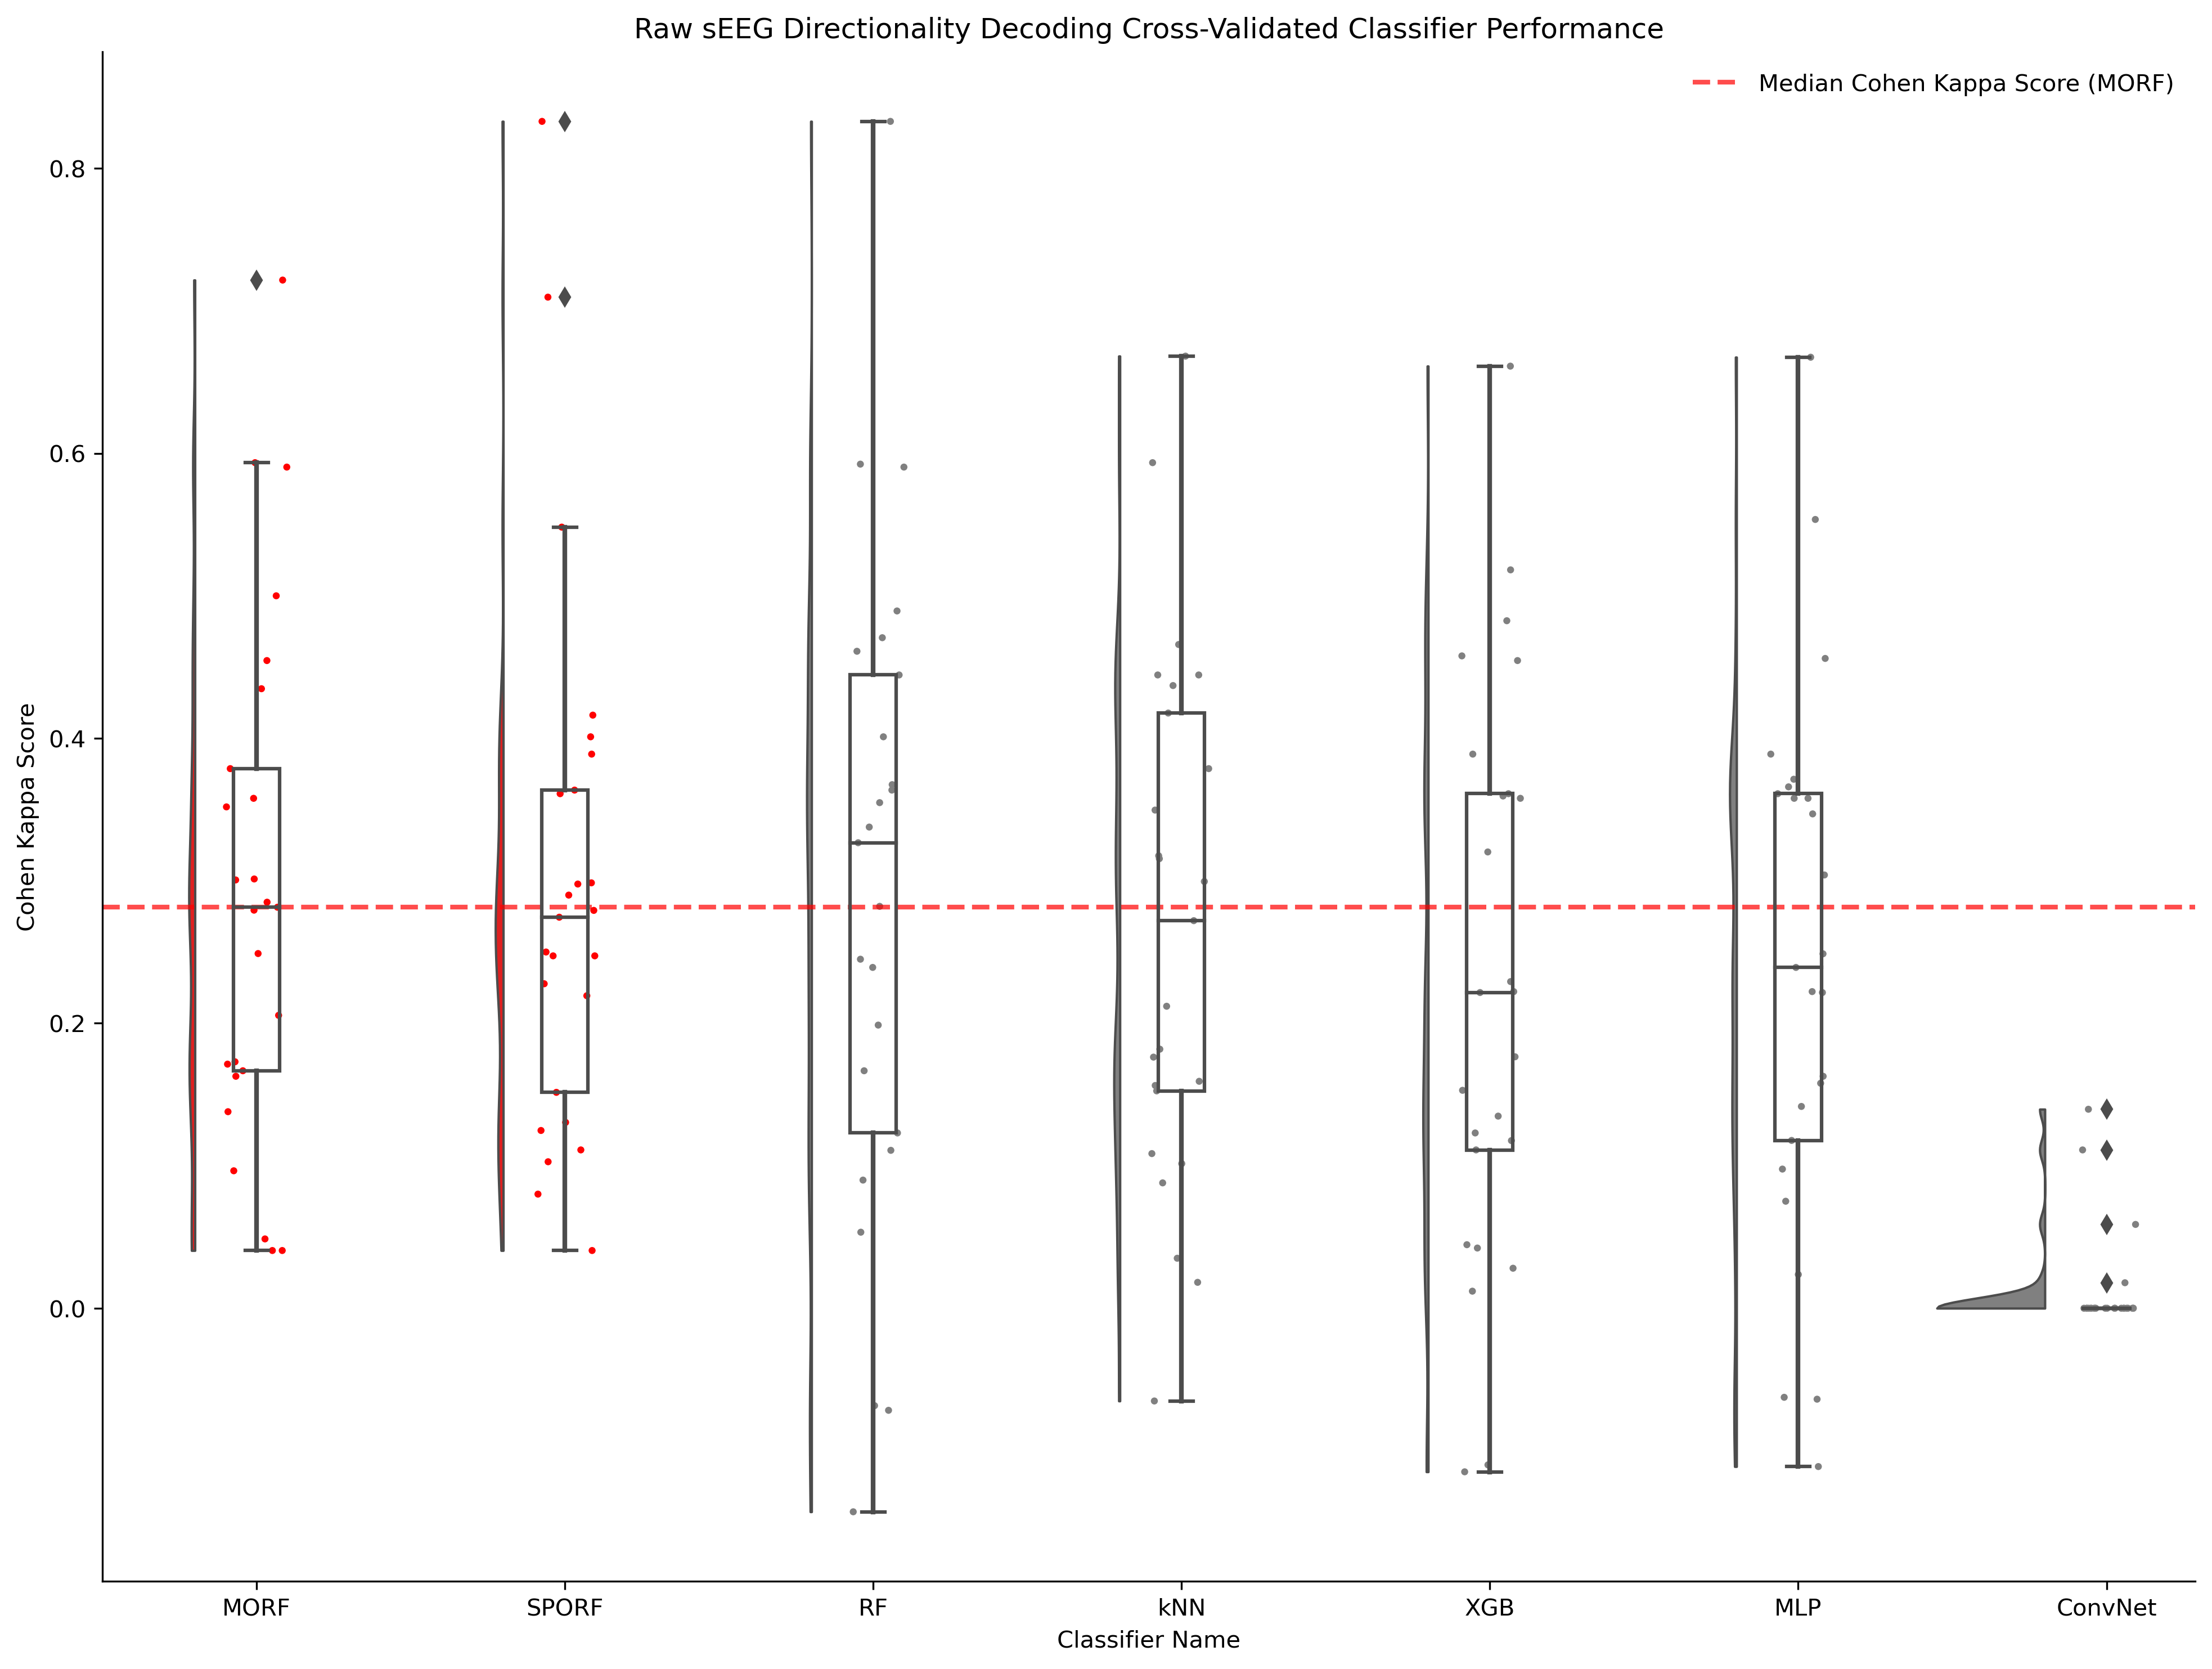

In [6]:
plot_classifier_comparison(cohort_clf_scores, "cohen_kappa_score");